In [45]:
import numpy as np
import optuna
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from optuna import Trial, Study
from braindecode.models import EEGNetv4, HybridNet, EEGResNet, TCN, EEGInceptionMI
from braindecode.augmentation import AugmentedDataLoader
from torch.utils.data import DataLoader, TensorDataset
from tqdm.auto import tqdm
from utils.training import train, best_torch_device
from torchinfo import summary
from copy import copy, deepcopy
from prepare_data import get_frequency_dataloader, get_raw_dataloader, get_sub1_dataloader, get_time_series_dataloader

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
bsz = 32

train_loader, val_loader, test_loader = get_raw_dataloader(batch_size=bsz)
train_aug_loader, _, _ = get_frequency_dataloader(batch_size=bsz)
train_sub_loader, val_sub_loader, test_sub_loader = get_sub1_dataloader(batch_size=bsz)


In [127]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.filter_nums1 = 16 # 8
        self.filter_nums2 = 80 # 40
        self.filter_nums3 = 24 # 12
        num_groups = 8
        b = True
        dropout_prob = 0.25

        self.conv_over_time = nn.Sequential(
            nn.Conv2d(1, self.filter_nums1, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=b),
            nn.BatchNorm2d(self.filter_nums1, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
        # (n, 8, 22, 1001)

        self.conv_over_channels = nn.Sequential(
            nn.Conv2d(self.filter_nums1, self.filter_nums2, kernel_size=(22, 1), stride=(1, 1), groups=num_groups, bias=b),
            nn.BatchNorm2d(self.filter_nums2, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0), # pool over time to shrink time
            nn.Dropout(p=dropout_prob)
        )
        # (n, 40, 1, 250)

        self.conv_by_channel_and_point = nn.Sequential(
            nn.Conv2d(self.filter_nums2, self.filter_nums2, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=num_groups, bias=b),
            # (n, 40, 1, 251)
            nn.Conv2d(self.filter_nums2, self.filter_nums3, kernel_size=(1, 1), stride=(1, 1), bias=False),
            # (n, 12, 1, 251)
            nn.BatchNorm2d(self.filter_nums3, eps=0.001, momentum=0.01, affine=True, track_running_stats=True),
            nn.ELU(),
            nn.AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0),
            nn.Dropout(p=dropout_prob),
            # (n, 12, 1, 31)
            nn.Conv2d(self.filter_nums3, 4, kernel_size=(1, 31), stride=(1, 1)) # conv to 4 output classes
            # (n, 4, 1, 1)
        )
        

    def forward(self, x):
        # x = x.to('mps')
        # X (batch, ch, t)
        x = x.unsqueeze(3)
        # (batch, ch, t, 1)
        x = x.permute(0, 3, 1, 2)
        # (batch, 1, ch, t)
        x = self.conv_over_time(x)
        x = self.conv_over_channels(x)
        x = self.conv_by_channel_and_point(x)
        x = x.squeeze(-1)
        x = x.squeeze(-1)
        return x

In [121]:
device = torch.device('mps')

model = CNN()
model = model.to(device)
print(model)
summary(model, input_size=(2, 22, 1000), device='mps')

CNN(
  (conv_over_time): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (conv_over_channels): Sequential(
    (0): Conv2d(16, 80, kernel_size=(22, 1), stride=(1, 1), groups=4)
    (1): BatchNorm2d(80, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.05, inplace=False)
  )
  (conv_by_channel_and_point): Sequential(
    (0): Conv2d(80, 80, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=4)
    (1): Conv2d(80, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5): Dropout(p=0.05, inplace=False)
    (6): Conv2d(24, 4, kernel_size=(1, 31), s

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [2, 4]                    --
├─Sequential: 1-1                        [2, 16, 22, 1001]         --
│    └─Conv2d: 2-1                       [2, 16, 22, 1001]         1,040
│    └─BatchNorm2d: 2-2                  [2, 16, 22, 1001]         32
├─Sequential: 1-2                        [2, 80, 1, 250]           --
│    └─Conv2d: 2-3                       [2, 80, 1, 1001]          7,120
│    └─BatchNorm2d: 2-4                  [2, 80, 1, 1001]          160
│    └─ELU: 2-5                          [2, 80, 1, 1001]          --
│    └─AvgPool2d: 2-6                    [2, 80, 1, 250]           --
│    └─Dropout: 2-7                      [2, 80, 1, 250]           --
├─Sequential: 1-3                        [2, 4, 1, 1]              --
│    └─Conv2d: 2-8                       [2, 80, 1, 251]           25,680
│    └─Conv2d: 2-9                       [2, 24, 1, 251]           1,920
│

## Train with raw data

In [70]:
from utils.training import train

raw_model = model
raw_model.to(device)

optimizer = torch.optim.Adam(raw_model.parameters(), lr=0.001, weight_decay=1e-03)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

tr_loader = train_loader

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=raw_model,
    optimizer=optimizer,
    loss_func=nn.CrossEntropyLoss(),
    train_data=tr_loader,
    val_data=val_loader,
    early_stopping_patience=10,
    scheduler=scheduler,
    cp_path="models/cnn",
    cp_filename="raw.pt",
    n_epochs=150,
    show_progress_bar=True,
)

Using device: mps


Epoch 0: 100%|██████████| 28/28 [00:09<00:00,  2.84batch/s, loss=1.3824]


[Epoch 0] val_acc=0.357988 train_acc=0.353405 val_loss=0.023736 train_loss=0.021379
Validation loss decreased (inf --> 0.023736).  Saving model ...


Epoch 1: 100%|██████████| 28/28 [00:07<00:00,  3.71batch/s, loss=1.1662]


[Epoch 1] val_acc=0.443787 train_acc=0.459201 val_loss=0.022913 train_loss=0.019640
Validation loss decreased (0.023736 --> 0.022913).  Saving model ...


Epoch 2: 100%|██████████| 28/28 [00:07<00:00,  3.58batch/s, loss=1.2602]


[Epoch 2] val_acc=0.434911 train_acc=0.551491 val_loss=0.021676 train_loss=0.018209
Validation loss decreased (0.022913 --> 0.021676).  Saving model ...


Epoch 3: 100%|██████████| 28/28 [00:07<00:00,  3.67batch/s, loss=1.0452]


[Epoch 3] val_acc=0.505917 train_acc=0.597636 val_loss=0.020794 train_loss=0.017345
Validation loss decreased (0.021676 --> 0.020794).  Saving model ...


Epoch 4: 100%|██████████| 28/28 [00:07<00:00,  3.66batch/s, loss=1.0705]


[Epoch 4] val_acc=0.544379 train_acc=0.625774 val_loss=0.020160 train_loss=0.016579
Validation loss decreased (0.020794 --> 0.020160).  Saving model ...


Epoch 5: 100%|██████████| 28/28 [00:07<00:00,  3.64batch/s, loss=0.9699]


[Epoch 5] val_acc=0.565089 train_acc=0.661227 val_loss=0.019387 train_loss=0.015974
Validation loss decreased (0.020160 --> 0.019387).  Saving model ...


Epoch 6: 100%|██████████| 28/28 [00:07<00:00,  3.70batch/s, loss=1.0447]


[Epoch 6] val_acc=0.550296 train_acc=0.672482 val_loss=0.019383 train_loss=0.015597
Validation loss decreased (0.019387 --> 0.019383).  Saving model ...


Epoch 7: 100%|██████████| 28/28 [00:07<00:00,  3.71batch/s, loss=1.0124]


[Epoch 7] val_acc=0.568047 train_acc=0.676984 val_loss=0.018573 train_loss=0.015461
Validation loss decreased (0.019383 --> 0.018573).  Saving model ...


Epoch 8: 100%|██████████| 28/28 [00:07<00:00,  3.64batch/s, loss=0.9403]


[Epoch 8] val_acc=0.573964 train_acc=0.716939 val_loss=0.018322 train_loss=0.014788
Validation loss decreased (0.018573 --> 0.018322).  Saving model ...


Epoch 9: 100%|██████████| 28/28 [00:08<00:00,  3.42batch/s, loss=0.9424]


[Epoch 9] val_acc=0.568047 train_acc=0.718627 val_loss=0.017688 train_loss=0.014722
Validation loss decreased (0.018322 --> 0.017688).  Saving model ...


Epoch 10: 100%|██████████| 28/28 [00:08<00:00,  3.45batch/s, loss=0.8313]


[Epoch 10] val_acc=0.615385 train_acc=0.732696 val_loss=0.016444 train_loss=0.014354
Validation loss decreased (0.017688 --> 0.016444).  Saving model ...


Epoch 11: 100%|██████████| 28/28 [00:08<00:00,  3.48batch/s, loss=0.9121]


[Epoch 11] val_acc=0.639053 train_acc=0.740574 val_loss=0.015971 train_loss=0.013913
Validation loss decreased (0.016444 --> 0.015971).  Saving model ...


Epoch 12: 100%|██████████| 28/28 [00:08<00:00,  3.35batch/s, loss=0.8729]


[Epoch 12] val_acc=0.630178 train_acc=0.764209 val_loss=0.016293 train_loss=0.013750
EarlyStopping counter: 1 out of 30


Epoch 13: 100%|██████████| 28/28 [00:08<00:00,  3.49batch/s, loss=1.0707]


[Epoch 13] val_acc=0.621302 train_acc=0.756331 val_loss=0.016292 train_loss=0.013756
EarlyStopping counter: 2 out of 30


Epoch 14: 100%|██████████| 28/28 [00:08<00:00,  3.38batch/s, loss=0.7368]


[Epoch 14] val_acc=0.650888 train_acc=0.770400 val_loss=0.015350 train_loss=0.013419
Validation loss decreased (0.015971 --> 0.015350).  Saving model ...


Epoch 15: 100%|██████████| 28/28 [00:08<00:00,  3.32batch/s, loss=0.8673]


[Epoch 15] val_acc=0.680473 train_acc=0.773213 val_loss=0.014377 train_loss=0.013399
Validation loss decreased (0.015350 --> 0.014377).  Saving model ...


Epoch 16: 100%|██████████| 28/28 [00:08<00:00,  3.38batch/s, loss=0.7201]


[Epoch 16] val_acc=0.656805 train_acc=0.790096 val_loss=0.015229 train_loss=0.012981
EarlyStopping counter: 1 out of 30


Epoch 17: 100%|██████████| 28/28 [00:08<00:00,  3.43batch/s, loss=0.7063]


[Epoch 17] val_acc=0.707101 train_acc=0.802476 val_loss=0.013987 train_loss=0.012956
Validation loss decreased (0.014377 --> 0.013987).  Saving model ...


Epoch 18: 100%|██████████| 28/28 [00:07<00:00,  3.73batch/s, loss=0.7665]


[Epoch 18] val_acc=0.680473 train_acc=0.808666 val_loss=0.014275 train_loss=0.012643
EarlyStopping counter: 1 out of 30


Epoch 19: 100%|██████████| 28/28 [00:08<00:00,  3.46batch/s, loss=0.8496]


[Epoch 19] val_acc=0.695266 train_acc=0.815982 val_loss=0.014335 train_loss=0.012564
EarlyStopping counter: 2 out of 30


Epoch 20: 100%|██████████| 28/28 [00:08<00:00,  3.45batch/s, loss=0.8162]


[Epoch 20] val_acc=0.707101 train_acc=0.813731 val_loss=0.013410 train_loss=0.012491
Validation loss decreased (0.013987 --> 0.013410).  Saving model ...


Epoch 21: 100%|██████████| 28/28 [00:08<00:00,  3.42batch/s, loss=0.7426]


[Epoch 21] val_acc=0.698225 train_acc=0.823860 val_loss=0.013821 train_loss=0.012318
EarlyStopping counter: 1 out of 30


Epoch 22: 100%|██████████| 28/28 [00:07<00:00,  3.51batch/s, loss=0.7893]


[Epoch 22] val_acc=0.718935 train_acc=0.828362 val_loss=0.013437 train_loss=0.012255
EarlyStopping counter: 2 out of 30


Epoch 23: 100%|██████████| 28/28 [00:08<00:00,  3.49batch/s, loss=0.7095]


[Epoch 23] val_acc=0.698225 train_acc=0.832864 val_loss=0.014214 train_loss=0.012152
EarlyStopping counter: 3 out of 30


Epoch 24: 100%|██████████| 28/28 [00:07<00:00,  3.60batch/s, loss=0.7462]


[Epoch 24] val_acc=0.689349 train_acc=0.833990 val_loss=0.014267 train_loss=0.012001
EarlyStopping counter: 4 out of 30


Epoch 25: 100%|██████████| 28/28 [00:07<00:00,  3.52batch/s, loss=0.7261]


[Epoch 25] val_acc=0.689349 train_acc=0.832864 val_loss=0.013676 train_loss=0.011950
EarlyStopping counter: 5 out of 30


Epoch 26: 100%|██████████| 28/28 [00:07<00:00,  3.64batch/s, loss=0.9240]


[Epoch 26] val_acc=0.671598 train_acc=0.841306 val_loss=0.014374 train_loss=0.011957
EarlyStopping counter: 6 out of 30


Epoch 27: 100%|██████████| 28/28 [00:07<00:00,  3.53batch/s, loss=0.6978]


[Epoch 27] val_acc=0.671598 train_acc=0.853123 val_loss=0.013923 train_loss=0.011676
EarlyStopping counter: 7 out of 30


Epoch 28: 100%|██████████| 28/28 [00:07<00:00,  3.57batch/s, loss=0.8211]


[Epoch 28] val_acc=0.715976 train_acc=0.859876 val_loss=0.013378 train_loss=0.011660
Validation loss decreased (0.013410 --> 0.013378).  Saving model ...


Epoch 29: 100%|██████████| 28/28 [00:08<00:00,  3.40batch/s, loss=0.8633]


[Epoch 29] val_acc=0.724852 train_acc=0.851435 val_loss=0.013158 train_loss=0.011779
Validation loss decreased (0.013378 --> 0.013158).  Saving model ...


Epoch 30: 100%|██████████| 28/28 [00:07<00:00,  3.73batch/s, loss=0.7769]


[Epoch 30] val_acc=0.692308 train_acc=0.853123 val_loss=0.013564 train_loss=0.011537
EarlyStopping counter: 1 out of 30


Epoch 31: 100%|██████████| 28/28 [00:07<00:00,  3.51batch/s, loss=0.6805]


[Epoch 31] val_acc=0.704142 train_acc=0.858751 val_loss=0.013557 train_loss=0.011488
EarlyStopping counter: 2 out of 30


Epoch 32: 100%|██████████| 28/28 [00:08<00:00,  3.38batch/s, loss=0.7070]


[Epoch 32] val_acc=0.683432 train_acc=0.858188 val_loss=0.013527 train_loss=0.011546
EarlyStopping counter: 3 out of 30


Epoch 33: 100%|██████████| 28/28 [00:08<00:00,  3.34batch/s, loss=0.7304]


[Epoch 33] val_acc=0.701183 train_acc=0.869443 val_loss=0.013189 train_loss=0.011430
EarlyStopping counter: 4 out of 30


Epoch 34: 100%|██████████| 28/28 [00:08<00:00,  3.33batch/s, loss=0.8200]


[Epoch 34] val_acc=0.689349 train_acc=0.873945 val_loss=0.013262 train_loss=0.011269
EarlyStopping counter: 5 out of 30


Epoch 35: 100%|██████████| 28/28 [00:08<00:00,  3.35batch/s, loss=0.7652]


[Epoch 35] val_acc=0.704142 train_acc=0.870006 val_loss=0.013103 train_loss=0.011414
Validation loss decreased (0.013158 --> 0.013103).  Saving model ...


Epoch 36: 100%|██████████| 28/28 [00:07<00:00,  3.55batch/s, loss=0.7243]


[Epoch 36] val_acc=0.718935 train_acc=0.882386 val_loss=0.013017 train_loss=0.011071
Validation loss decreased (0.013103 --> 0.013017).  Saving model ...


Epoch 37: 100%|██████████| 28/28 [00:08<00:00,  3.48batch/s, loss=0.7928]


[Epoch 37] val_acc=0.730769 train_acc=0.877321 val_loss=0.012945 train_loss=0.011126
Validation loss decreased (0.013017 --> 0.012945).  Saving model ...


Epoch 38: 100%|██████████| 28/28 [00:08<00:00,  3.35batch/s, loss=0.7915]


[Epoch 38] val_acc=0.698225 train_acc=0.872819 val_loss=0.013419 train_loss=0.011234
EarlyStopping counter: 1 out of 30


Epoch 39: 100%|██████████| 28/28 [00:07<00:00,  3.55batch/s, loss=0.7916]


[Epoch 39] val_acc=0.683432 train_acc=0.871131 val_loss=0.013756 train_loss=0.011160
EarlyStopping counter: 2 out of 30


Epoch 40: 100%|██████████| 28/28 [00:07<00:00,  3.58batch/s, loss=0.6915]


[Epoch 40] val_acc=0.698225 train_acc=0.879010 val_loss=0.013827 train_loss=0.011064
EarlyStopping counter: 3 out of 30


Epoch 41: 100%|██████████| 28/28 [00:07<00:00,  3.56batch/s, loss=0.6851]


[Epoch 41] val_acc=0.715976 train_acc=0.889702 val_loss=0.012930 train_loss=0.010964
Validation loss decreased (0.012945 --> 0.012930).  Saving model ...


Epoch 42: 100%|██████████| 28/28 [00:07<00:00,  3.57batch/s, loss=0.7252]


[Epoch 42] val_acc=0.715976 train_acc=0.882386 val_loss=0.013183 train_loss=0.010999
EarlyStopping counter: 1 out of 30


Epoch 43: 100%|██████████| 28/28 [00:07<00:00,  3.58batch/s, loss=0.6928]


[Epoch 43] val_acc=0.692308 train_acc=0.889139 val_loss=0.012964 train_loss=0.010779
EarlyStopping counter: 2 out of 30


Epoch 44: 100%|██████████| 28/28 [00:08<00:00,  3.42batch/s, loss=0.6752]


[Epoch 44] val_acc=0.713018 train_acc=0.891390 val_loss=0.013204 train_loss=0.010925
EarlyStopping counter: 3 out of 30


Epoch 45: 100%|██████████| 28/28 [00:08<00:00,  3.25batch/s, loss=0.6583]


[Epoch 45] val_acc=0.724852 train_acc=0.892515 val_loss=0.012722 train_loss=0.010754
Validation loss decreased (0.012930 --> 0.012722).  Saving model ...


Epoch 46: 100%|██████████| 28/28 [00:08<00:00,  3.32batch/s, loss=0.6588]


[Epoch 46] val_acc=0.704142 train_acc=0.900394 val_loss=0.013077 train_loss=0.010632
EarlyStopping counter: 1 out of 30


Epoch 47: 100%|██████████| 28/28 [00:08<00:00,  3.25batch/s, loss=0.6617]


[Epoch 47] val_acc=0.707101 train_acc=0.893641 val_loss=0.013109 train_loss=0.010755
EarlyStopping counter: 2 out of 30


Epoch 48: 100%|██████████| 28/28 [00:08<00:00,  3.37batch/s, loss=0.6801]


[Epoch 48] val_acc=0.686391 train_acc=0.909398 val_loss=0.013510 train_loss=0.010529
EarlyStopping counter: 3 out of 30


Epoch 49: 100%|██████████| 28/28 [00:08<00:00,  3.42batch/s, loss=0.7154]


[Epoch 49] val_acc=0.698225 train_acc=0.903208 val_loss=0.013134 train_loss=0.010586
EarlyStopping counter: 4 out of 30


Epoch 50: 100%|██████████| 28/28 [00:08<00:00,  3.27batch/s, loss=0.6738]


[Epoch 50] val_acc=0.707101 train_acc=0.910523 val_loss=0.012807 train_loss=0.010533
EarlyStopping counter: 5 out of 30


Epoch 51: 100%|██████████| 28/28 [00:08<00:00,  3.13batch/s, loss=0.6417]


[Epoch 51] val_acc=0.724852 train_acc=0.906584 val_loss=0.012981 train_loss=0.010547
EarlyStopping counter: 6 out of 30


Epoch 52: 100%|██████████| 28/28 [00:08<00:00,  3.27batch/s, loss=0.6216]


[Epoch 52] val_acc=0.715976 train_acc=0.891390 val_loss=0.012448 train_loss=0.010824
Validation loss decreased (0.012722 --> 0.012448).  Saving model ...


Epoch 53: 100%|██████████| 28/28 [00:08<00:00,  3.16batch/s, loss=0.6715]


[Epoch 53] val_acc=0.680473 train_acc=0.917276 val_loss=0.013793 train_loss=0.010492
EarlyStopping counter: 1 out of 30


Epoch 54: 100%|██████████| 28/28 [00:09<00:00,  3.07batch/s, loss=0.6350]


[Epoch 54] val_acc=0.713018 train_acc=0.909961 val_loss=0.013172 train_loss=0.010427
EarlyStopping counter: 2 out of 30


Epoch 55: 100%|██████████| 28/28 [00:09<00:00,  2.95batch/s, loss=0.7180]


[Epoch 55] val_acc=0.713018 train_acc=0.913337 val_loss=0.013183 train_loss=0.010414
EarlyStopping counter: 3 out of 30


Epoch 56: 100%|██████████| 28/28 [00:11<00:00,  2.46batch/s, loss=0.6755]


[Epoch 56] val_acc=0.742604 train_acc=0.913337 val_loss=0.013214 train_loss=0.010476
EarlyStopping counter: 4 out of 30


Epoch 57: 100%|██████████| 28/28 [00:13<00:00,  2.12batch/s, loss=0.6473]


[Epoch 57] val_acc=0.692308 train_acc=0.899268 val_loss=0.013186 train_loss=0.010573
EarlyStopping counter: 5 out of 30


Epoch 58: 100%|██████████| 28/28 [00:11<00:00,  2.46batch/s, loss=0.7765]


[Epoch 58] val_acc=0.689349 train_acc=0.907710 val_loss=0.012988 train_loss=0.010481
EarlyStopping counter: 6 out of 30


Epoch 59: 100%|██████████| 28/28 [00:12<00:00,  2.25batch/s, loss=0.7132]


[Epoch 59] val_acc=0.701183 train_acc=0.900957 val_loss=0.012635 train_loss=0.010446
EarlyStopping counter: 7 out of 30


Epoch 60: 100%|██████████| 28/28 [00:10<00:00,  2.62batch/s, loss=0.6524]


[Epoch 60] val_acc=0.695266 train_acc=0.920653 val_loss=0.012452 train_loss=0.010304
EarlyStopping counter: 8 out of 30


Epoch 61: 100%|██████████| 28/28 [00:10<00:00,  2.64batch/s, loss=0.6966]


[Epoch 61] val_acc=0.710059 train_acc=0.913337 val_loss=0.013085 train_loss=0.010414
EarlyStopping counter: 9 out of 30


Epoch 62: 100%|██████████| 28/28 [00:11<00:00,  2.39batch/s, loss=0.7116]


[Epoch 62] val_acc=0.695266 train_acc=0.913900 val_loss=0.013038 train_loss=0.010316
EarlyStopping counter: 10 out of 30


Epoch 63: 100%|██████████| 28/28 [00:11<00:00,  2.50batch/s, loss=0.5942]


[Epoch 63] val_acc=0.710059 train_acc=0.921778 val_loss=0.012664 train_loss=0.010194
EarlyStopping counter: 11 out of 30


Epoch 64: 100%|██████████| 28/28 [00:11<00:00,  2.37batch/s, loss=0.6421]


[Epoch 64] val_acc=0.721893 train_acc=0.926843 val_loss=0.012839 train_loss=0.010182
EarlyStopping counter: 12 out of 30


Epoch 65: 100%|██████████| 28/28 [00:11<00:00,  2.41batch/s, loss=0.6743]


[Epoch 65] val_acc=0.718935 train_acc=0.924592 val_loss=0.012677 train_loss=0.010161
EarlyStopping counter: 13 out of 30


Epoch 66: 100%|██████████| 28/28 [00:10<00:00,  2.74batch/s, loss=0.6732]


[Epoch 66] val_acc=0.715976 train_acc=0.918965 val_loss=0.012462 train_loss=0.010218
EarlyStopping counter: 14 out of 30


Epoch 67: 100%|██████████| 28/28 [00:09<00:00,  2.96batch/s, loss=0.6665]


[Epoch 67] val_acc=0.715976 train_acc=0.919527 val_loss=0.012787 train_loss=0.010255
EarlyStopping counter: 15 out of 30


Epoch 68: 100%|██████████| 28/28 [00:09<00:00,  2.92batch/s, loss=0.6470]


[Epoch 68] val_acc=0.704142 train_acc=0.920090 val_loss=0.013260 train_loss=0.010178
EarlyStopping counter: 16 out of 30


Epoch 69: 100%|██████████| 28/28 [00:10<00:00,  2.67batch/s, loss=0.6178]


[Epoch 69] val_acc=0.713018 train_acc=0.920653 val_loss=0.013157 train_loss=0.010237
EarlyStopping counter: 17 out of 30


Epoch 70: 100%|██████████| 28/28 [00:08<00:00,  3.13batch/s, loss=0.6844]


[Epoch 70] val_acc=0.710059 train_acc=0.920653 val_loss=0.013036 train_loss=0.010163
EarlyStopping counter: 18 out of 30


Epoch 71: 100%|██████████| 28/28 [00:08<00:00,  3.16batch/s, loss=0.7044]


[Epoch 71] val_acc=0.707101 train_acc=0.928531 val_loss=0.013127 train_loss=0.010137
EarlyStopping counter: 19 out of 30


Epoch 72: 100%|██████████| 28/28 [00:08<00:00,  3.31batch/s, loss=0.6244]


[Epoch 72] val_acc=0.698225 train_acc=0.936410 val_loss=0.013219 train_loss=0.010030
EarlyStopping counter: 20 out of 30


Epoch 73: 100%|██████████| 28/28 [00:09<00:00,  2.87batch/s, loss=0.7031]


[Epoch 73] val_acc=0.713018 train_acc=0.925155 val_loss=0.012814 train_loss=0.010070
EarlyStopping counter: 21 out of 30


Epoch 74: 100%|██████████| 28/28 [00:10<00:00,  2.74batch/s, loss=0.6117]


[Epoch 74] val_acc=0.736686 train_acc=0.933033 val_loss=0.012408 train_loss=0.009929
Validation loss decreased (0.012448 --> 0.012408).  Saving model ...


Epoch 75: 100%|██████████| 28/28 [00:10<00:00,  2.63batch/s, loss=0.6387]


[Epoch 75] val_acc=0.701183 train_acc=0.938661 val_loss=0.012986 train_loss=0.009933
EarlyStopping counter: 1 out of 30


Epoch 76: 100%|██████████| 28/28 [00:08<00:00,  3.20batch/s, loss=0.6503]


[Epoch 76] val_acc=0.724852 train_acc=0.926280 val_loss=0.012720 train_loss=0.010058
EarlyStopping counter: 2 out of 30


Epoch 77: 100%|██████████| 28/28 [00:09<00:00,  2.86batch/s, loss=0.6352]


[Epoch 77] val_acc=0.695266 train_acc=0.928531 val_loss=0.012692 train_loss=0.009921
EarlyStopping counter: 3 out of 30


Epoch 78: 100%|██████████| 28/28 [00:10<00:00,  2.78batch/s, loss=0.5831]


[Epoch 78] val_acc=0.701183 train_acc=0.933033 val_loss=0.013387 train_loss=0.010118
EarlyStopping counter: 4 out of 30


Epoch 79: 100%|██████████| 28/28 [00:09<00:00,  2.98batch/s, loss=0.6811]


[Epoch 79] val_acc=0.701183 train_acc=0.931908 val_loss=0.013444 train_loss=0.010023
EarlyStopping counter: 5 out of 30


Epoch 80: 100%|██████████| 28/28 [00:09<00:00,  3.05batch/s, loss=0.6541]


[Epoch 80] val_acc=0.692308 train_acc=0.934159 val_loss=0.013381 train_loss=0.010041
EarlyStopping counter: 6 out of 30


Epoch 81: 100%|██████████| 28/28 [00:08<00:00,  3.19batch/s, loss=0.6434]


[Epoch 81] val_acc=0.695266 train_acc=0.933033 val_loss=0.012793 train_loss=0.010073
EarlyStopping counter: 7 out of 30


Epoch 82: 100%|██████████| 28/28 [00:08<00:00,  3.17batch/s, loss=0.6042]


[Epoch 82] val_acc=0.704142 train_acc=0.920653 val_loss=0.012888 train_loss=0.010104
EarlyStopping counter: 8 out of 30


Epoch 83: 100%|██████████| 28/28 [00:08<00:00,  3.48batch/s, loss=0.6701]


[Epoch 83] val_acc=0.715976 train_acc=0.943725 val_loss=0.012754 train_loss=0.009804
EarlyStopping counter: 9 out of 30


Epoch 84: 100%|██████████| 28/28 [00:08<00:00,  3.21batch/s, loss=0.6302]


[Epoch 84] val_acc=0.715976 train_acc=0.940912 val_loss=0.013059 train_loss=0.009862
EarlyStopping counter: 10 out of 30


Epoch 85: 100%|██████████| 28/28 [00:08<00:00,  3.30batch/s, loss=0.6116]


[Epoch 85] val_acc=0.707101 train_acc=0.935847 val_loss=0.012762 train_loss=0.009925
EarlyStopping counter: 11 out of 30


Epoch 86: 100%|██████████| 28/28 [00:09<00:00,  2.98batch/s, loss=0.6276]


[Epoch 86] val_acc=0.692308 train_acc=0.939786 val_loss=0.013372 train_loss=0.009757
EarlyStopping counter: 12 out of 30


Epoch 87: 100%|██████████| 28/28 [00:08<00:00,  3.17batch/s, loss=0.6512]


[Epoch 87] val_acc=0.692308 train_acc=0.938661 val_loss=0.012984 train_loss=0.009738
EarlyStopping counter: 13 out of 30


Epoch 88: 100%|██████████| 28/28 [00:08<00:00,  3.43batch/s, loss=0.6045]


[Epoch 88] val_acc=0.713018 train_acc=0.936972 val_loss=0.013197 train_loss=0.009830
EarlyStopping counter: 14 out of 30


Epoch 89: 100%|██████████| 28/28 [00:08<00:00,  3.40batch/s, loss=0.6511]


[Epoch 89] val_acc=0.704142 train_acc=0.943163 val_loss=0.013207 train_loss=0.009788
EarlyStopping counter: 15 out of 30


Epoch 90: 100%|██████████| 28/28 [00:08<00:00,  3.14batch/s, loss=0.6432]


[Epoch 90] val_acc=0.701183 train_acc=0.942037 val_loss=0.013320 train_loss=0.009839
EarlyStopping counter: 16 out of 30


Epoch 91: 100%|██████████| 28/28 [00:08<00:00,  3.38batch/s, loss=0.6242]


[Epoch 91] val_acc=0.710059 train_acc=0.933596 val_loss=0.012923 train_loss=0.009745
EarlyStopping counter: 17 out of 30


Epoch 92: 100%|██████████| 28/28 [00:08<00:00,  3.34batch/s, loss=0.6782]


[Epoch 92] val_acc=0.727811 train_acc=0.942037 val_loss=0.012888 train_loss=0.009860
EarlyStopping counter: 18 out of 30


Epoch 93: 100%|██████████| 28/28 [00:08<00:00,  3.23batch/s, loss=0.6255]


[Epoch 93] val_acc=0.718935 train_acc=0.949353 val_loss=0.012794 train_loss=0.009650
EarlyStopping counter: 19 out of 30


Epoch 94: 100%|██████████| 28/28 [00:10<00:00,  2.75batch/s, loss=0.6840]


[Epoch 94] val_acc=0.730769 train_acc=0.944851 val_loss=0.013210 train_loss=0.009760
EarlyStopping counter: 20 out of 30


Epoch 95: 100%|██████████| 28/28 [00:09<00:00,  2.95batch/s, loss=0.5924]


[Epoch 95] val_acc=0.733728 train_acc=0.938098 val_loss=0.012835 train_loss=0.009771
EarlyStopping counter: 21 out of 30


Epoch 96: 100%|██████████| 28/28 [00:08<00:00,  3.33batch/s, loss=0.6399]


[Epoch 96] val_acc=0.730769 train_acc=0.948227 val_loss=0.012703 train_loss=0.009595
EarlyStopping counter: 22 out of 30


Epoch 97: 100%|██████████| 28/28 [00:08<00:00,  3.47batch/s, loss=0.5955]


[Epoch 97] val_acc=0.721893 train_acc=0.947102 val_loss=0.012409 train_loss=0.009614
EarlyStopping counter: 23 out of 30


Epoch 98: 100%|██████████| 28/28 [00:09<00:00,  2.90batch/s, loss=0.5913]


[Epoch 98] val_acc=0.710059 train_acc=0.951604 val_loss=0.013081 train_loss=0.009608
EarlyStopping counter: 24 out of 30


Epoch 99: 100%|██████████| 28/28 [00:09<00:00,  2.99batch/s, loss=0.6222]


[Epoch 99] val_acc=0.718935 train_acc=0.942600 val_loss=0.012344 train_loss=0.009715
Validation loss decreased (0.012408 --> 0.012344).  Saving model ...


Epoch 100: 100%|██████████| 28/28 [00:08<00:00,  3.12batch/s, loss=0.6167]


[Epoch 100] val_acc=0.707101 train_acc=0.948227 val_loss=0.012740 train_loss=0.009588
EarlyStopping counter: 1 out of 30


Epoch 101: 100%|██████████| 28/28 [00:08<00:00,  3.21batch/s, loss=0.6197]


[Epoch 101] val_acc=0.713018 train_acc=0.952167 val_loss=0.012931 train_loss=0.009548
EarlyStopping counter: 2 out of 30


Epoch 102: 100%|██████████| 28/28 [00:09<00:00,  3.05batch/s, loss=0.6695]


[Epoch 102] val_acc=0.710059 train_acc=0.943725 val_loss=0.012926 train_loss=0.009639
EarlyStopping counter: 3 out of 30


Epoch 103: 100%|██████████| 28/28 [00:08<00:00,  3.46batch/s, loss=0.6057]


[Epoch 103] val_acc=0.701183 train_acc=0.942037 val_loss=0.012893 train_loss=0.009671
EarlyStopping counter: 4 out of 30


Epoch 104: 100%|██████████| 28/28 [00:08<00:00,  3.42batch/s, loss=0.5528]


[Epoch 104] val_acc=0.724852 train_acc=0.957231 val_loss=0.012415 train_loss=0.009364
EarlyStopping counter: 5 out of 30


Epoch 105: 100%|██████████| 28/28 [00:11<00:00,  2.49batch/s, loss=0.6174]


[Epoch 105] val_acc=0.701183 train_acc=0.951041 val_loss=0.012665 train_loss=0.009477
EarlyStopping counter: 6 out of 30


Epoch 106: 100%|██████████| 28/28 [00:09<00:00,  2.99batch/s, loss=0.6340]


[Epoch 106] val_acc=0.715976 train_acc=0.949353 val_loss=0.012833 train_loss=0.009527
EarlyStopping counter: 7 out of 30


Epoch 107: 100%|██████████| 28/28 [00:08<00:00,  3.15batch/s, loss=0.5928]


[Epoch 107] val_acc=0.704142 train_acc=0.940912 val_loss=0.013019 train_loss=0.009797
EarlyStopping counter: 8 out of 30


Epoch 108: 100%|██████████| 28/28 [00:10<00:00,  2.65batch/s, loss=0.5940]


[Epoch 108] val_acc=0.686391 train_acc=0.952167 val_loss=0.013315 train_loss=0.009476
EarlyStopping counter: 9 out of 30


Epoch 109: 100%|██████████| 28/28 [00:09<00:00,  3.06batch/s, loss=0.6416]


[Epoch 109] val_acc=0.713018 train_acc=0.944288 val_loss=0.012829 train_loss=0.009625
EarlyStopping counter: 10 out of 30


Epoch 110: 100%|██████████| 28/28 [00:09<00:00,  2.81batch/s, loss=0.6111]


[Epoch 110] val_acc=0.736686 train_acc=0.955543 val_loss=0.012487 train_loss=0.009433
EarlyStopping counter: 11 out of 30


Epoch 111: 100%|██████████| 28/28 [00:11<00:00,  2.54batch/s, loss=0.6109]


[Epoch 111] val_acc=0.724852 train_acc=0.960608 val_loss=0.012783 train_loss=0.009274
EarlyStopping counter: 12 out of 30


Epoch 112: 100%|██████████| 28/28 [00:10<00:00,  2.59batch/s, loss=0.6037]


[Epoch 112] val_acc=0.727811 train_acc=0.970174 val_loss=0.012678 train_loss=0.009177
EarlyStopping counter: 13 out of 30


Epoch 113: 100%|██████████| 28/28 [00:09<00:00,  2.92batch/s, loss=0.6085]


[Epoch 113] val_acc=0.736686 train_acc=0.965672 val_loss=0.012632 train_loss=0.009183
EarlyStopping counter: 14 out of 30


Epoch 114: 100%|██████████| 28/28 [00:09<00:00,  2.91batch/s, loss=0.6033]


[Epoch 114] val_acc=0.727811 train_acc=0.964547 val_loss=0.012353 train_loss=0.009205
EarlyStopping counter: 15 out of 30


Epoch 115: 100%|██████████| 28/28 [00:10<00:00,  2.65batch/s, loss=0.5685]


[Epoch 115] val_acc=0.713018 train_acc=0.963984 val_loss=0.012905 train_loss=0.009259
EarlyStopping counter: 16 out of 30


Epoch 116: 100%|██████████| 28/28 [00:09<00:00,  2.95batch/s, loss=0.5950]


[Epoch 116] val_acc=0.724852 train_acc=0.973551 val_loss=0.012747 train_loss=0.009082
EarlyStopping counter: 17 out of 30


Epoch 117: 100%|██████████| 28/28 [00:10<00:00,  2.72batch/s, loss=0.6002]


[Epoch 117] val_acc=0.733728 train_acc=0.971300 val_loss=0.012637 train_loss=0.009110
EarlyStopping counter: 18 out of 30


Epoch 118: 100%|██████████| 28/28 [00:10<00:00,  2.73batch/s, loss=0.6479]


[Epoch 118] val_acc=0.721893 train_acc=0.972425 val_loss=0.012655 train_loss=0.009214
EarlyStopping counter: 19 out of 30


Epoch 119: 100%|██████████| 28/28 [00:10<00:00,  2.61batch/s, loss=0.5834]


[Epoch 119] val_acc=0.727811 train_acc=0.973551 val_loss=0.012559 train_loss=0.009082
EarlyStopping counter: 20 out of 30


Epoch 120: 100%|██████████| 28/28 [00:10<00:00,  2.62batch/s, loss=0.6160]


[Epoch 120] val_acc=0.736686 train_acc=0.971863 val_loss=0.012712 train_loss=0.009062
EarlyStopping counter: 21 out of 30


Epoch 121: 100%|██████████| 28/28 [00:09<00:00,  3.04batch/s, loss=0.6102]


[Epoch 121] val_acc=0.730769 train_acc=0.974114 val_loss=0.012692 train_loss=0.009073
EarlyStopping counter: 22 out of 30


Epoch 122: 100%|██████████| 28/28 [00:08<00:00,  3.38batch/s, loss=0.5966]


[Epoch 122] val_acc=0.736686 train_acc=0.966235 val_loss=0.012530 train_loss=0.009133
EarlyStopping counter: 23 out of 30


Epoch 123: 100%|██████████| 28/28 [00:09<00:00,  3.01batch/s, loss=0.5942]


[Epoch 123] val_acc=0.715976 train_acc=0.967923 val_loss=0.012802 train_loss=0.009097
EarlyStopping counter: 24 out of 30


Epoch 124: 100%|██████████| 28/28 [00:08<00:00,  3.38batch/s, loss=0.5588]


[Epoch 124] val_acc=0.727811 train_acc=0.980304 val_loss=0.012949 train_loss=0.008948
EarlyStopping counter: 25 out of 30


Epoch 125: 100%|██████████| 28/28 [00:08<00:00,  3.13batch/s, loss=0.6124]


[Epoch 125] val_acc=0.739645 train_acc=0.971300 val_loss=0.012890 train_loss=0.009144
EarlyStopping counter: 26 out of 30


Epoch 126: 100%|██████████| 28/28 [00:09<00:00,  2.93batch/s, loss=0.5754]


[Epoch 126] val_acc=0.704142 train_acc=0.974676 val_loss=0.013009 train_loss=0.009064
EarlyStopping counter: 27 out of 30


Epoch 127: 100%|██████████| 28/28 [00:09<00:00,  2.96batch/s, loss=0.5622]


[Epoch 127] val_acc=0.736686 train_acc=0.969049 val_loss=0.012571 train_loss=0.009071
EarlyStopping counter: 28 out of 30


Epoch 128: 100%|██████████| 28/28 [00:08<00:00,  3.44batch/s, loss=0.5727]


[Epoch 128] val_acc=0.724852 train_acc=0.970737 val_loss=0.012558 train_loss=0.009054
EarlyStopping counter: 29 out of 30


Epoch 129: 100%|██████████| 28/28 [00:08<00:00,  3.16batch/s, loss=0.5821]


[Epoch 129] val_acc=0.721893 train_acc=0.978053 val_loss=0.013117 train_loss=0.009037
EarlyStopping counter: 30 out of 30
Early stopping.


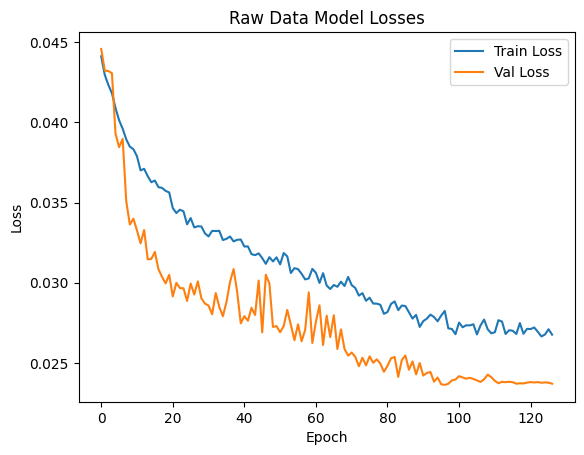

In [130]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

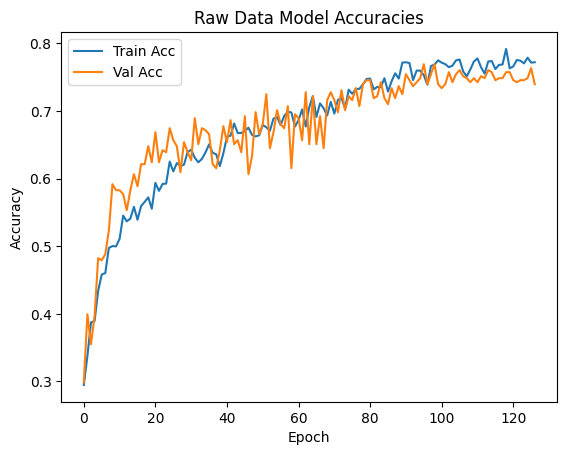

In [131]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Raw Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [138]:
# Load best model and test
raw_model = torch.load("models/cnn/raw.pt")
raw_model.to(device)
raw_model.eval()

CNN(
  (conv_over_time): Sequential(
    (0): Conv2d(1, 20, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32), bias=False)
    (1): BatchNorm2d(20, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (conv_over_channels): Sequential(
    (0): Conv2d(20, 48, kernel_size=(22, 1), stride=(1, 1), groups=4, bias=False)
    (1): BatchNorm2d(48, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv_by_channel_and_point): Sequential(
    (0): Conv2d(48, 48, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=4, bias=False)
    (1): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5): Dropout(p=0.2, inplace=False)
    (6): Co

In [139]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_loader.dataset)
print("Train on raw data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on raw data
Test Acc: 0.6930


In [140]:
# Evaluate on sub1 data
test_acc = 0
with torch.no_grad():
    for X, y in test_sub_loader:
        X, y = X.to(device), y.to(device)
        y_pred = raw_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_sub_loader.dataset)
print("Train on raw data, evaluate on sub1 data")
print(f"Test Acc: {test_acc:.4f}")

Train on raw data, evaluate on sub1 data
Test Acc: 0.7400


## Train with augmented data with FT surrogate

In [128]:
device = torch.device('mps')

model = CNN()
model = model.to(device)
print(model)
summary(model, input_size=(1, 22, 1000), device='mps')

CNN(
  (conv_over_time): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (conv_over_channels): Sequential(
    (0): Conv2d(16, 80, kernel_size=(22, 1), stride=(1, 1), groups=8)
    (1): BatchNorm2d(80, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv_by_channel_and_point): Sequential(
    (0): Conv2d(80, 80, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=8)
    (1): Conv2d(80, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(24, 4, kernel_size=(1, 31), s

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 4]                    --
├─Sequential: 1-1                        [1, 16, 22, 1001]         --
│    └─Conv2d: 2-1                       [1, 16, 22, 1001]         1,040
│    └─BatchNorm2d: 2-2                  [1, 16, 22, 1001]         32
├─Sequential: 1-2                        [1, 80, 1, 250]           --
│    └─Conv2d: 2-3                       [1, 80, 1, 1001]          3,600
│    └─BatchNorm2d: 2-4                  [1, 80, 1, 1001]          160
│    └─ELU: 2-5                          [1, 80, 1, 1001]          --
│    └─AvgPool2d: 2-6                    [1, 80, 1, 250]           --
│    └─Dropout: 2-7                      [1, 80, 1, 250]           --
├─Sequential: 1-3                        [1, 4, 1, 1]              --
│    └─Conv2d: 2-8                       [1, 80, 1, 251]           12,880
│    └─Conv2d: 2-9                       [1, 24, 1, 251]           1,920
│

In [145]:
aug_model = torch.load("models/cnn/aug_best.pt")
aug_model.to(device)

CNN(
  (conv_over_time): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (conv_over_channels): Sequential(
    (0): Conv2d(16, 80, kernel_size=(22, 1), stride=(1, 1), groups=8)
    (1): BatchNorm2d(80, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv_by_channel_and_point): Sequential(
    (0): Conv2d(80, 80, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=8)
    (1): Conv2d(80, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(24, 4, kernel_size=(1, 31), s

In [146]:
from utils.training import train

aug_model = model
aug_model.to(device)

optimizer = torch.optim.Adam(aug_model.parameters(), lr=0.00001,  weight_decay=0.000001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

tr_loader = train_aug_loader

train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train(
    model=aug_model,
    optimizer=optimizer,
    loss_func=nn.CrossEntropyLoss(),
    train_data=tr_loader,
    val_data=val_loader,
    early_stopping_patience=30,
    scheduler=scheduler,
    cp_path="models/cnn",
    cp_filename="aug.pt",
    n_epochs=150,
    show_progress_bar=True,
)

/Users/yubo/miniforge3/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Using device: mps


Epoch 0: 100%|██████████| 56/56 [00:10<00:00,  5.52batch/s, loss=0.8138]


[Epoch 0] val_acc=0.748521 train_acc=0.777715 val_loss=0.023728 train_loss=0.027127
Validation loss decreased (inf --> 0.023728).  Saving model ...


Epoch 1: 100%|██████████| 56/56 [00:09<00:00,  6.04batch/s, loss=0.9587]


[Epoch 1] val_acc=0.748521 train_acc=0.770400 val_loss=0.023711 train_loss=0.027209
Validation loss decreased (0.023728 --> 0.023711).  Saving model ...


Epoch 2: 100%|██████████| 56/56 [00:09<00:00,  6.10batch/s, loss=0.7194]


[Epoch 2] val_acc=0.745562 train_acc=0.779966 val_loss=0.023715 train_loss=0.026605
EarlyStopping counter: 1 out of 30


Epoch 3: 100%|██████████| 56/56 [00:09<00:00,  6.07batch/s, loss=0.8748]


[Epoch 3] val_acc=0.742604 train_acc=0.773213 val_loss=0.023735 train_loss=0.027156
EarlyStopping counter: 2 out of 30


Epoch 4: 100%|██████████| 56/56 [00:09<00:00,  6.05batch/s, loss=0.8081]


[Epoch 4] val_acc=0.742604 train_acc=0.766460 val_loss=0.023722 train_loss=0.027013
EarlyStopping counter: 3 out of 30


Epoch 5: 100%|██████████| 56/56 [00:10<00:00,  5.37batch/s, loss=0.9267]


[Epoch 5] val_acc=0.739645 train_acc=0.760833 val_loss=0.023726 train_loss=0.027278
EarlyStopping counter: 4 out of 30


Epoch 6: 100%|██████████| 56/56 [00:11<00:00,  5.07batch/s, loss=0.8309]


[Epoch 6] val_acc=0.742604 train_acc=0.776027 val_loss=0.023736 train_loss=0.027021
EarlyStopping counter: 5 out of 30


Epoch 7: 100%|██████████| 56/56 [00:10<00:00,  5.41batch/s, loss=0.8544]


[Epoch 7] val_acc=0.748521 train_acc=0.769837 val_loss=0.023739 train_loss=0.027185
EarlyStopping counter: 6 out of 30


Epoch 8: 100%|██████████| 56/56 [00:10<00:00,  5.35batch/s, loss=0.8168]


[Epoch 8] val_acc=0.754438 train_acc=0.799662 val_loss=0.023784 train_loss=0.026190
EarlyStopping counter: 7 out of 30


Epoch 9: 100%|██████████| 56/56 [00:10<00:00,  5.40batch/s, loss=0.9101]


[Epoch 9] val_acc=0.748521 train_acc=0.771525 val_loss=0.023764 train_loss=0.026876
EarlyStopping counter: 8 out of 30


Epoch 10: 100%|██████████| 56/56 [00:10<00:00,  5.59batch/s, loss=1.0871]


[Epoch 10] val_acc=0.748521 train_acc=0.779966 val_loss=0.023741 train_loss=0.026781
EarlyStopping counter: 9 out of 30


Epoch 11: 100%|██████████| 56/56 [00:09<00:00,  5.73batch/s, loss=0.9063]


[Epoch 11] val_acc=0.748521 train_acc=0.776590 val_loss=0.023741 train_loss=0.026785
EarlyStopping counter: 10 out of 30


Epoch 12: 100%|██████████| 56/56 [00:09<00:00,  5.94batch/s, loss=0.8552]


[Epoch 12] val_acc=0.751479 train_acc=0.769837 val_loss=0.023706 train_loss=0.027073
Validation loss decreased (0.023711 --> 0.023706).  Saving model ...


Epoch 13: 100%|██████████| 56/56 [00:09<00:00,  5.98batch/s, loss=0.6485]


[Epoch 13] val_acc=0.748521 train_acc=0.769274 val_loss=0.023696 train_loss=0.026735
Validation loss decreased (0.023706 --> 0.023696).  Saving model ...


Epoch 14: 100%|██████████| 56/56 [00:09<00:00,  5.97batch/s, loss=0.8048]


[Epoch 14] val_acc=0.748521 train_acc=0.767023 val_loss=0.023684 train_loss=0.027019
Validation loss decreased (0.023696 --> 0.023684).  Saving model ...


Epoch 15: 100%|██████████| 56/56 [00:10<00:00,  5.48batch/s, loss=0.8121]


[Epoch 15] val_acc=0.745562 train_acc=0.761396 val_loss=0.023689 train_loss=0.027328
EarlyStopping counter: 1 out of 30


Epoch 16: 100%|██████████| 56/56 [00:09<00:00,  6.02batch/s, loss=0.7657]


[Epoch 16] val_acc=0.745562 train_acc=0.752392 val_loss=0.023684 train_loss=0.027270
EarlyStopping counter: 2 out of 30


Epoch 17: 100%|██████████| 56/56 [00:09<00:00,  6.02batch/s, loss=0.8395]


[Epoch 17] val_acc=0.748521 train_acc=0.781654 val_loss=0.023686 train_loss=0.026878
EarlyStopping counter: 3 out of 30


Epoch 18: 100%|██████████| 56/56 [00:09<00:00,  6.03batch/s, loss=0.8413]


[Epoch 18] val_acc=0.751479 train_acc=0.757456 val_loss=0.023686 train_loss=0.027648
EarlyStopping counter: 4 out of 30


Epoch 19: 100%|██████████| 56/56 [00:10<00:00,  5.55batch/s, loss=0.7391]


[Epoch 19] val_acc=0.748521 train_acc=0.778841 val_loss=0.023686 train_loss=0.026851
EarlyStopping counter: 5 out of 30


Epoch 20: 100%|██████████| 56/56 [00:10<00:00,  5.58batch/s, loss=1.0236]


[Epoch 20] val_acc=0.748521 train_acc=0.763084 val_loss=0.023686 train_loss=0.027029
EarlyStopping counter: 6 out of 30


Epoch 21: 100%|██████████| 56/56 [00:09<00:00,  5.73batch/s, loss=0.8379]


[Epoch 21] val_acc=0.751479 train_acc=0.776027 val_loss=0.023690 train_loss=0.026677
EarlyStopping counter: 7 out of 30


Epoch 22: 100%|██████████| 56/56 [00:10<00:00,  5.28batch/s, loss=0.6887]


[Epoch 22] val_acc=0.751479 train_acc=0.772651 val_loss=0.023696 train_loss=0.026765
EarlyStopping counter: 8 out of 30


Epoch 23: 100%|██████████| 56/56 [00:10<00:00,  5.59batch/s, loss=0.7054]


[Epoch 23] val_acc=0.751479 train_acc=0.767586 val_loss=0.023699 train_loss=0.027245
EarlyStopping counter: 9 out of 30


Epoch 24: 100%|██████████| 56/56 [00:10<00:00,  5.14batch/s, loss=1.1054]


[Epoch 24] val_acc=0.751479 train_acc=0.780529 val_loss=0.023681 train_loss=0.026660
Validation loss decreased (0.023684 --> 0.023681).  Saving model ...


Epoch 25: 100%|██████████| 56/56 [00:10<00:00,  5.32batch/s, loss=0.7669]


[Epoch 25] val_acc=0.751479 train_acc=0.780529 val_loss=0.023680 train_loss=0.026678
Validation loss decreased (0.023681 --> 0.023680).  Saving model ...


Epoch 26: 100%|██████████| 56/56 [00:09<00:00,  5.89batch/s, loss=0.9740]


[Epoch 26] val_acc=0.751479 train_acc=0.779403 val_loss=0.023687 train_loss=0.026758
EarlyStopping counter: 1 out of 30


Epoch 27: 100%|██████████| 56/56 [00:09<00:00,  5.87batch/s, loss=1.1913]


[Epoch 27] val_acc=0.748521 train_acc=0.781654 val_loss=0.023696 train_loss=0.026738
EarlyStopping counter: 2 out of 30


Epoch 28: 100%|██████████| 56/56 [00:09<00:00,  5.87batch/s, loss=0.9325]


[Epoch 28] val_acc=0.751479 train_acc=0.776590 val_loss=0.023696 train_loss=0.026982
EarlyStopping counter: 3 out of 30


Epoch 29: 100%|██████████| 56/56 [00:09<00:00,  5.88batch/s, loss=0.9544]


[Epoch 29] val_acc=0.748521 train_acc=0.768711 val_loss=0.023691 train_loss=0.027118
EarlyStopping counter: 4 out of 30


Epoch 30: 100%|██████████| 56/56 [00:09<00:00,  5.89batch/s, loss=0.7251]


[Epoch 30] val_acc=0.748521 train_acc=0.790096 val_loss=0.023690 train_loss=0.026393
EarlyStopping counter: 5 out of 30


Epoch 31: 100%|██████████| 56/56 [00:10<00:00,  5.37batch/s, loss=0.9091]


[Epoch 31] val_acc=0.748521 train_acc=0.783905 val_loss=0.023693 train_loss=0.026453
EarlyStopping counter: 6 out of 30


Epoch 32: 100%|██████████| 56/56 [00:09<00:00,  5.81batch/s, loss=0.7091]


[Epoch 32] val_acc=0.751479 train_acc=0.773213 val_loss=0.023685 train_loss=0.027239
EarlyStopping counter: 7 out of 30


Epoch 33: 100%|██████████| 56/56 [00:09<00:00,  5.85batch/s, loss=0.8987]


[Epoch 33] val_acc=0.751479 train_acc=0.773776 val_loss=0.023706 train_loss=0.027369
EarlyStopping counter: 8 out of 30


Epoch 34: 100%|██████████| 56/56 [00:09<00:00,  5.82batch/s, loss=0.8926]


[Epoch 34] val_acc=0.748521 train_acc=0.772651 val_loss=0.023701 train_loss=0.026891
EarlyStopping counter: 9 out of 30


Epoch 35: 100%|██████████| 56/56 [00:09<00:00,  5.78batch/s, loss=0.9891]


[Epoch 35] val_acc=0.751479 train_acc=0.788970 val_loss=0.023691 train_loss=0.026667
EarlyStopping counter: 10 out of 30


Epoch 36: 100%|██████████| 56/56 [00:09<00:00,  5.74batch/s, loss=0.7658]


[Epoch 36] val_acc=0.751479 train_acc=0.768149 val_loss=0.023700 train_loss=0.026861
EarlyStopping counter: 11 out of 30


Epoch 37: 100%|██████████| 56/56 [00:09<00:00,  5.88batch/s, loss=0.9333]


[Epoch 37] val_acc=0.751479 train_acc=0.781654 val_loss=0.023692 train_loss=0.026961
EarlyStopping counter: 12 out of 30


Epoch 38: 100%|██████████| 56/56 [00:09<00:00,  5.79batch/s, loss=0.8243]


[Epoch 38] val_acc=0.751479 train_acc=0.781654 val_loss=0.023691 train_loss=0.026899
EarlyStopping counter: 13 out of 30


Epoch 39: 100%|██████████| 56/56 [00:09<00:00,  5.82batch/s, loss=0.9145]


[Epoch 39] val_acc=0.751479 train_acc=0.774339 val_loss=0.023690 train_loss=0.026975
EarlyStopping counter: 14 out of 30


Epoch 40: 100%|██████████| 56/56 [00:09<00:00,  5.69batch/s, loss=1.0311]


[Epoch 40] val_acc=0.751479 train_acc=0.771525 val_loss=0.023694 train_loss=0.027378
EarlyStopping counter: 15 out of 30


Epoch 41: 100%|██████████| 56/56 [00:09<00:00,  5.67batch/s, loss=0.8432]


[Epoch 41] val_acc=0.751479 train_acc=0.779966 val_loss=0.023708 train_loss=0.027090
EarlyStopping counter: 16 out of 30


Epoch 42: 100%|██████████| 56/56 [00:09<00:00,  5.71batch/s, loss=0.7748]


[Epoch 42] val_acc=0.751479 train_acc=0.784468 val_loss=0.023705 train_loss=0.026608
EarlyStopping counter: 17 out of 30


Epoch 43: 100%|██████████| 56/56 [00:09<00:00,  5.62batch/s, loss=0.8079]


[Epoch 43] val_acc=0.748521 train_acc=0.767023 val_loss=0.023723 train_loss=0.026924
EarlyStopping counter: 18 out of 30


Epoch 44: 100%|██████████| 56/56 [00:09<00:00,  5.62batch/s, loss=0.8062]


[Epoch 44] val_acc=0.751479 train_acc=0.769274 val_loss=0.023710 train_loss=0.026925
EarlyStopping counter: 19 out of 30


Epoch 45: 100%|██████████| 56/56 [00:10<00:00,  5.34batch/s, loss=1.0731]


[Epoch 45] val_acc=0.751479 train_acc=0.770962 val_loss=0.023703 train_loss=0.027078
EarlyStopping counter: 20 out of 30


Epoch 46: 100%|██████████| 56/56 [00:10<00:00,  5.46batch/s, loss=0.8360]


[Epoch 46] val_acc=0.751479 train_acc=0.781092 val_loss=0.023702 train_loss=0.026741
EarlyStopping counter: 21 out of 30


Epoch 47: 100%|██████████| 56/56 [00:10<00:00,  5.48batch/s, loss=0.8162]


[Epoch 47] val_acc=0.751479 train_acc=0.767586 val_loss=0.023707 train_loss=0.026774
EarlyStopping counter: 22 out of 30


Epoch 48: 100%|██████████| 56/56 [00:10<00:00,  5.45batch/s, loss=1.0226]


[Epoch 48] val_acc=0.751479 train_acc=0.763647 val_loss=0.023707 train_loss=0.026867
EarlyStopping counter: 23 out of 30


Epoch 49: 100%|██████████| 56/56 [00:10<00:00,  5.55batch/s, loss=0.7607]


[Epoch 49] val_acc=0.751479 train_acc=0.759707 val_loss=0.023709 train_loss=0.026803
EarlyStopping counter: 24 out of 30


Epoch 50: 100%|██████████| 56/56 [00:10<00:00,  5.38batch/s, loss=0.9647]


[Epoch 50] val_acc=0.751479 train_acc=0.785031 val_loss=0.023708 train_loss=0.026671
EarlyStopping counter: 25 out of 30


Epoch 51: 100%|██████████| 56/56 [00:10<00:00,  5.42batch/s, loss=0.7403]


[Epoch 51] val_acc=0.751479 train_acc=0.769837 val_loss=0.023703 train_loss=0.026919
EarlyStopping counter: 26 out of 30


Epoch 52: 100%|██████████| 56/56 [00:10<00:00,  5.28batch/s, loss=0.9539]


[Epoch 52] val_acc=0.751479 train_acc=0.790658 val_loss=0.023708 train_loss=0.026683
EarlyStopping counter: 27 out of 30


Epoch 53: 100%|██████████| 56/56 [00:11<00:00,  4.91batch/s, loss=0.8273]


[Epoch 53] val_acc=0.748521 train_acc=0.774339 val_loss=0.023710 train_loss=0.026828
EarlyStopping counter: 28 out of 30


Epoch 54: 100%|██████████| 56/56 [00:10<00:00,  5.24batch/s, loss=0.9179]


[Epoch 54] val_acc=0.748521 train_acc=0.790658 val_loss=0.023709 train_loss=0.026598
EarlyStopping counter: 29 out of 30


Epoch 55: 100%|██████████| 56/56 [00:10<00:00,  5.40batch/s, loss=0.7617]


[Epoch 55] val_acc=0.748521 train_acc=0.778278 val_loss=0.023703 train_loss=0.026792
EarlyStopping counter: 30 out of 30
Early stopping.


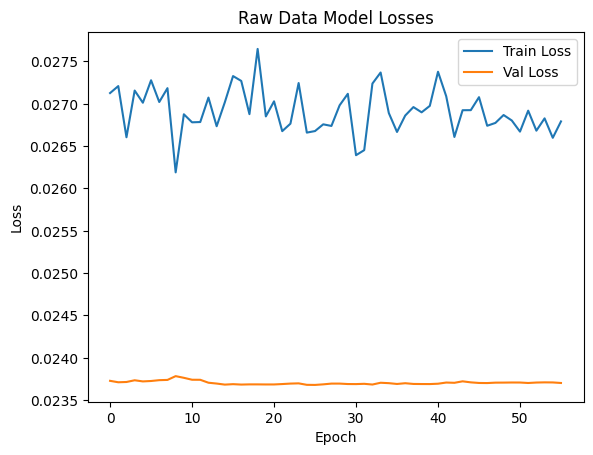

In [147]:
plt.plot(train_loss_hist, label="Train Loss")
plt.plot(val_loss_hist, label="Val Loss")
plt.title("Raw Data Model Losses")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

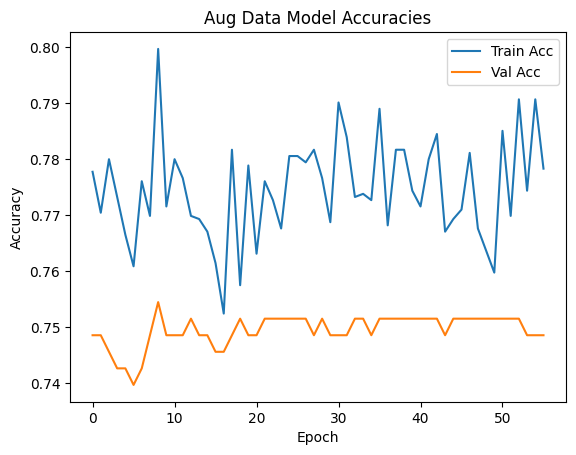

In [148]:
plt.plot(train_acc_hist, label="Train Acc")
plt.plot(val_acc_hist, label="Val Acc")
plt.title("Aug Data Model Accuracies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [149]:
# Load best model and test
aug_model = torch.load("models/cnn/aug.pt")
aug_model.to(device)
aug_model.eval()

CNN(
  (conv_over_time): Sequential(
    (0): Conv2d(1, 16, kernel_size=(1, 64), stride=(1, 1), padding=(0, 32))
    (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
  )
  (conv_over_channels): Sequential(
    (0): Conv2d(16, 80, kernel_size=(22, 1), stride=(1, 1), groups=8)
    (1): BatchNorm2d(80, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): AvgPool2d(kernel_size=(1, 4), stride=(1, 4), padding=0)
    (4): Dropout(p=0.25, inplace=False)
  )
  (conv_by_channel_and_point): Sequential(
    (0): Conv2d(80, 80, kernel_size=(1, 16), stride=(1, 1), padding=(0, 8), groups=8)
    (1): Conv2d(80, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(24, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
    (3): ELU(alpha=1.0)
    (4): AvgPool2d(kernel_size=(1, 8), stride=(1, 8), padding=0)
    (5): Dropout(p=0.25, inplace=False)
    (6): Conv2d(24, 4, kernel_size=(1, 31), s

In [150]:
# Evaluate on raw data
test_acc = 0
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        y_pred = aug_model(X)
        test_acc += (y_pred.argmax(dim=1) == y.argmax(dim=1)).sum().item()
test_acc /= len(test_loader.dataset)
print("Train on aug data, evaluate on raw data")
print(f"Test Acc: {test_acc:.4f}")

Train on aug data, evaluate on raw data
Test Acc: 0.7156
